# CNN Opción A: etiqueta por lado activo + 500k muestras

Propósito: remapear la etiqueta (0/1/2) al lado activo cuando mueve negras y entrenar con un conjunto mayor (≈500k train, 100k val/test).

## Conceptos
- Perspectiva: si juega negras, swapcase de colores y flip vertical de filas (no columnas).
- Opción A: la etiqueta se remapea cuando juega negras: `cls = 2 - cls` → clases relativas al lado activo.
- Target: evaluación a centipawns; mates → ±10000 cp; umbrales ±150 cp.
- Modelo: CNN regularizada (BN + Dropout + L2 + GAP).

In [1]:
from pathlib import Path
import os, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

DATA_DIR = Path('../data/processed')
assert (DATA_DIR / 'training_data.parquet').exists(), 'Falta data procesada. Ejecuta el split previo.'

## Parser de evaluación → cp y clases (±150 cp)

In [2]:
def eval_to_centipawns(eval_str: str) -> float:
    s = str(eval_str).strip()
    if not s: return 0.0
    if s.startswith('#'):
        try:
            v = float(s[1:])
            return 10000.0 if v >= 0 else -10000.0
        except Exception:
            return 0.0
    try:
        v = float(s)
    except Exception:
        return 0.0
    return v * 100.0 if '.' in s else v

def cp_to_class(cp: float, thr: int = 150) -> int:
    if cp > thr: return 0
    if cp < -thr: return 2
    return 1

# Sanidad rápida
tests = ['#3', '#-2', '+34', '-178', '2.5', '-1.8', '0.0']
[(t, eval_to_centipawns(t), cp_to_class(eval_to_centipawns(t))) for t in tests]

[('#3', 10000.0, 0),
 ('#-2', -10000.0, 2),
 ('+34', 34.0, 1),
 ('-178', -178.0, 2),
 ('2.5', 250.0, 0),
 ('-1.8', -180.0, 2),
 ('0.0', 0.0, 1)]

## FEN → tensor 8×8×12 (swapcase + flip vertical si juega negras)

In [3]:
def create_piece_mapping():
    pieces = ['P','N','B','R','Q','K']
    return {p: i for i, p in enumerate(pieces)}

PIECE_MAPPING = create_piece_mapping()

def parse_board_row(row_string: str, piece_mapping: dict) -> list[list[int]]:
    row_squares = []
    for ch in row_string:
        vec = [0] * (len(piece_mapping) * 2)
        if ch in piece_mapping:
            vec[piece_mapping[ch]] = 1; row_squares.append(vec)
        elif ch.upper() in piece_mapping:
            vec[piece_mapping[ch.upper()] + len(piece_mapping)] = 1; row_squares.append(vec)
        elif ch.isdigit():
            for _ in range(int(ch)): row_squares.append(vec.copy())
    return row_squares

def parse_fen_to_tensor_fixed(fen_string: str, piece_mapping: dict):
    parts = fen_string.split(' ')
    board = parts[0]
    active = parts[1] if len(parts) > 1 else 'w'
    is_black_turn = (active == 'b')
    if is_black_turn:
        board_proc = board.swapcase(); rows = list(reversed(board_proc.split('/')))
    else:
        rows = board.split('/')
    board_rows = [parse_board_row(r, piece_mapping) for r in rows]
    tensor = np.array(board_rows, dtype=np.float32)
    return tensor, is_black_turn

# Comprobación simple
initial = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
parse_fen_to_tensor_fixed(initial, PIECE_MAPPING)[0].shape

(8, 8, 12)

## Opción A: preprocesamiento con remapeo de etiqueta al lado activo

In [4]:
def preprocess_row_active(row: pd.Series, piece_mapping: dict):
    fen = row['FEN']; ev = row['Evaluation']
    board_tensor, is_black_turn = parse_fen_to_tensor_fixed(fen, piece_mapping)
    cp = eval_to_centipawns(str(ev))
    cls = cp_to_class(cp)
    # Remapeo al lado activo: si juega negras, 0↔2 (ventaja/desventaja)
    if is_black_turn:
        cls = 2 - cls
    y = np.zeros(3, dtype=np.float32); y[cls] = 1.0
    return board_tensor, y

def create_Xy_sampled(df: pd.DataFrame, n: int | None, seed: int = 42):
    if n is not None and n < len(df):
        df = df.sample(n=n, random_state=seed)
    X_list, y_list = [], []
    for _, r in df.iterrows():
        try:
            x, y = preprocess_row_active(r, PIECE_MAPPING)
            X_list.append(x); y_list.append(y)
        except Exception:
            continue
    X = np.stack(X_list, axis=0); y = np.stack(y_list, axis=0)
    return X, y

## Carga de datos y tamaños (500k/100k/100k)

In [5]:
MAX_TRAIN = int(os.environ.get('MAX_TRAIN', 500_000))
MAX_VAL   = int(os.environ.get('MAX_VAL',   100_000))
MAX_TEST  = int(os.environ.get('MAX_TEST',  100_000))

train_df = pd.read_parquet(DATA_DIR / 'training_data.parquet')
val_df   = pd.read_parquet(DATA_DIR / 'validation_data.parquet')
test_df  = pd.read_parquet(DATA_DIR / 'testing_data.parquet')
print(f'Train pool: {len(train_df):,} | Val pool: {len(val_df):,} | Test pool: {len(test_df):,}')

# Estimación de memoria (~4KB por muestra)
def est_gb(n): return (n * 4096) / (1024**3)
print(f'Est. RAM X_train: ~{est_gb(MAX_TRAIN):.2f} GB, X_val: ~{est_gb(MAX_VAL):.2f} GB, X_test: ~{est_gb(MAX_TEST):.2f} GB')

X_train, y_train = create_Xy_sampled(train_df, MAX_TRAIN)
gc.collect()
X_val,   y_val   = create_Xy_sampled(val_df,   MAX_VAL)
gc.collect()
X_test,  y_test  = create_Xy_sampled(test_df,  MAX_TEST)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

Train pool: 11,610,568 | Val pool: 3,317,307 | Test pool: 1,658,652
Est. RAM X_train: ~1.91 GB, X_val: ~0.38 GB, X_test: ~0.38 GB


((500000, 8, 8, 12),
 (500000, 3),
 (100000, 8, 8, 12),
 (100000, 3),
 (100000, 8, 8, 12),
 (100000, 3))

## Distribución de clases (train)

In [6]:
cls_counts = y_train.sum(axis=0)
tot = len(y_train); pct = cls_counts / tot * 100
print(f'Clase 0 (ventaja lado activo): {cls_counts[0]:.0f} ({pct[0]:.1f}%)')
print(f'Clase 1 (empate):              {cls_counts[1]:.0f} ({pct[1]:.1f}%)')
print(f'Clase 2 (desventaja):          {cls_counts[2]:.0f} ({pct[2]:.1f}%)')

Clase 0 (ventaja lado activo): 149000 (29.8%)
Clase 1 (empate):              239100 (47.8%)
Clase 2 (desventaja):          111900 (22.4%)


## Modelo regularizado (igual al refactor)

In [7]:
def build_model(input_shape=(8,8,12), l2w=1e-4, dp=0.4):
    m = Sequential([
        Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(l2w), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(l2w)),
        BatchNormalization(),
        Dropout(dp),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu', kernel_regularizer=l2(l2w)),
        Dropout(dp),
        Dense(3, activation='softmax')
    ])
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return m

model_active = build_model()
model_active.summary()

c:\Users\samir\Documents\noveno semestre\aprendizaje maquina\stocksalmon\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 64)       │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,771 (190.51 KB)

 Trainable params: 48,515 (189.51 KB)

 Non-trainable params: 256 (1.00 KB)

## Entrenamiento (early stopping + LR scheduler)

Epoch 1/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - categorical_accuracy: 0.5993 - loss: 0.8812 - val_categorical_accuracy: 0.6112 - val_loss: 0.8619 - learning_rate: 0.0010
Epoch 2/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - categorical_accuracy: 0.6242 - loss: 0.8492 - val_categorical_accuracy: 0.6263 - val_loss: 0.8496 - learning_rate: 0.0010
Epoch 3/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - categorical_accuracy: 0.6317 - loss: 0.8397 - val_categorical_accuracy: 0.6456 - val_loss: 0.8168 - learning_rate: 0.0010
Epoch 4/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - categorical_accuracy: 0.6364 - loss: 0.8342 - val_categorical_accuracy: 0.6335 - val_loss: 0.8286 - learning_rate: 0.0010
Epoch 5/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - categorical_accuracy: 0.6384 - loss: 0.8312 - val_categorical_accuracy: 0.6458 - val_loss: 0.8185 - learning_rate: 0.0010
Epoch 6/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.6412 - loss: 0.8285
Epoch

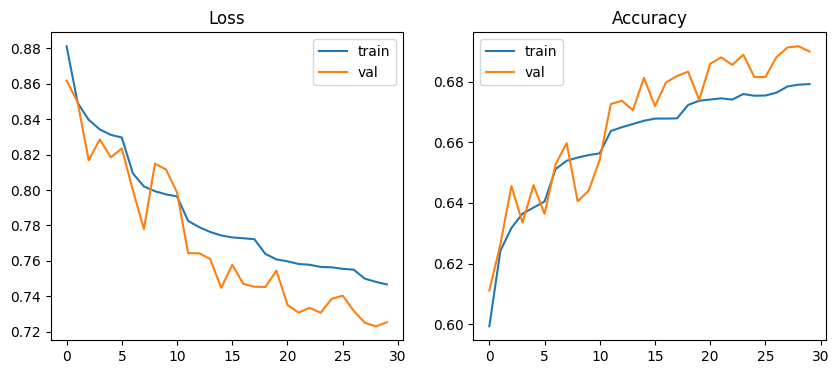

In [8]:
early = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
rlr   = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

history = model_active.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=64,
    callbacks=[early, rlr],
    verbose=1
)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(history.history['loss'], label='train'); ax[0].plot(history.history['val_loss'], label='val'); ax[0].set_title('Loss'); ax[0].legend();
ax[1].plot(history.history['categorical_accuracy'], label='train'); ax[1].plot(history.history['val_categorical_accuracy'], label='val'); ax[1].set_title('Accuracy'); ax[1].legend();
plt.show()

## Evaluación en test (reporte y matriz de confusión)

              precision    recall  f1-score   support

     Ventaja       0.69      0.55      0.61     29708
      Empate       0.72      0.82      0.77     47897
  Desventaja       0.63      0.60      0.61     22395

    accuracy                           0.69    100000
   macro avg       0.68      0.66      0.66    100000
weighted avg       0.69      0.69      0.69    100000



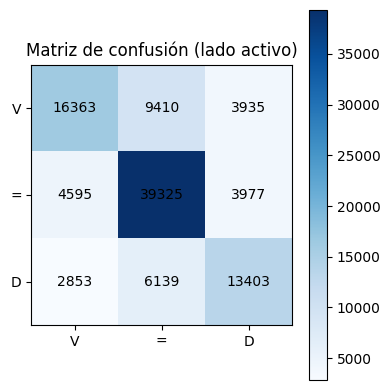

In [9]:
pred = model_active.predict(X_test, verbose=0)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(pred, axis=1)
print(classification_report(y_true, y_pred, target_names=['Ventaja','Empate','Desventaja']))
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
ax.set_xticklabels(['V','=', 'D']); ax.set_yticklabels(['V','=', 'D'])
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center')
ax.set_title('Matriz de confusión (lado activo)'); plt.colorbar(im); plt.tight_layout(); plt.show()